# 本筆記將帶大家用Keras建模
# 此範例使用MNIST手寫數字資料集

---

# 索引

[1. 資料準備](#I.-資料準備)
  * [1.a. 載入圖片](#1.a.-載入圖片)
  * [1.b. 利用Pandas可迅速了解每個資料夾裡面有幾張圖片](#1.b.-利用Pandas可迅速了解每個資料夾裡面有幾張圖片)
  * [1.c. 將圖片路徑資料切割成三份：取其80%做為train-data。 之後，剩下的20%中的10%做validation data，10%做test data](#1.c.-將圖片路徑資料切割成三份：取其80%做為train-data。-之後，剩下的20%中的10%做validation-data，10%做test-data)
  * [1.d. 將圖片載入，存成數值矩陣](#1.d.-將圖片載入，存成數值矩陣)
  

[2. Softmax Regression](#2.-Softmax-Regression)

  * [2.a. 將y 轉成one hot形式](#2.a.-將y-轉成one-hot形式)
  * [2.b. 開始建立模型](#2.b.-開始建立模型)
  * [2.c. 開始訓練模型](#2.c.-開始訓練模型)
  * [2.d. 檢視訓練好的模型用於test data有多少準確率](#2.d.-檢視訓練好的模型用於test-data有多少準確率)
  * [2.e. 檢視50筆測試資料的預測結果，以稍為了解預測是否還算ok](#2.e.-檢視50筆測試資料的預測結果，以稍為了解預測是否還算ok)
  * [2.f. 畫出模型訓練過程](#2.f.-畫出模型訓練過程)
  * [2.g. 儲存模型和權重](#2.g.-儲存模型和權重)
  * [2.h. 載入存好的模型和權重](#2.h.-載入存好的模型和權重)
  * [2.i. 輸出分類報告](#2.i.-輸出分類報告)
  
[3. AlexNet-like Network](#III.-AlexNet-like-Network)

  * [3.a. 建立模型](#3.a.-建立模型)
  * [3.b. 訓練模型](#3.b.-訓練模型)
  * [3.c. 檢視模型訓練結果](#3.c.-檢視模型訓練結果)
  * [3.d. 檢視模型準確率](#3.d.-檢視模型準確率)
  * [3.e. 檢視分類報告](#3.e.-檢視分類報告)
  
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pandas as pd
import sklearn
import os

import keras

Using TensorFlow backend.


In [2]:
keras.__version__

'2.0.8'

---

### 0. 下載資料

In [3]:
from zipfile import ZipFile
from urllib.request import urlretrieve

print('retrieving MNIST data...')
theurl = 'https://github.com/chi-hung/PythonTutorial/raw/master/datasets/mnist.tar.gz'
filename='mnist.tar.gz'
name, hdrs = urlretrieve(theurl, filename)

print('extracting MNIST data...')
res=!tar -xvf {filename}

print('done!')

retrieving MNIST data...
extracting MNIST data...
done!


### 1. 資料準備

#### 1.a. 載入圖片

In [4]:
def filePathsGen(rootPath):
    '''此函數將rootPath資料夾目錄中的所有圖片路徑資訊儲存至一個清單內。'''
    paths=[]
    dirs=[]
    for dirPath,dirNames,fileNames in os.walk(rootPath):
        for fileName in fileNames:
            fullPath=os.path.join(dirPath,fileName)
            paths.append((int(dirPath[len(rootPath) ]),fullPath))
        dirs.append(dirNames)
    return dirs,paths

In [5]:
dirs,paths=filePathsGen('mnist/') #載入圖片路徑

dfPath=pd.DataFrame(paths,columns=['class','path']) #圖片路徑存成Pandas資料表
dfPath.head(3) # 看資料表前3個row

,class,path
0,7,mnist/7/27302.jpg
1,7,mnist/7/17031.jpg
2,7,mnist/7/08280.jpg


[回索引](#索引)

#### 1.b. 利用Pandas可迅速了解每個資料夾裡面有幾張圖片

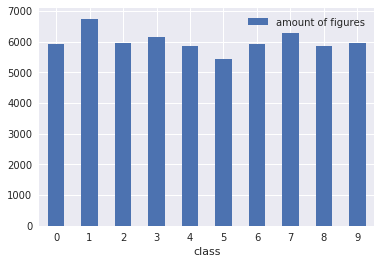

In [6]:
#依照class分群後，數各群的數量，並繪圖
dfCountPerClass=dfPath.groupby('class').count()
dfCountPerClass.rename(columns={'path':'amount of figures'},inplace=True)
dfCountPerClass.plot(kind='bar',rot=0)

[回索引](#索引)

####  1.c. 將圖片路徑資料切割成三份：取其80%做為train data。 之後，剩下的20%中的10%做validation data，10%做test data

shape(all figures)=		 (60000, 2)
shape(fraction of figures)=	 (18000, 2)
shape(train)=			 (12600, 2)
shape(trainVal)=		 (1800, 2)
shape(test)=			 (3600, 2)


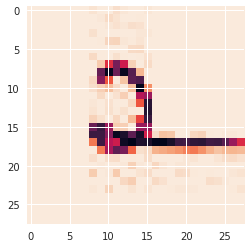

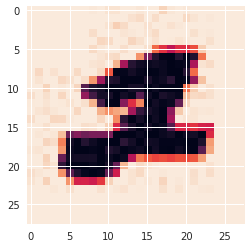

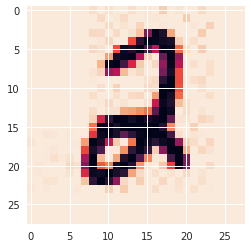

In [7]:
dfFiguresShuffled=dfPath.sample(frac=1)    # 打亂一下path data

dfFrac=dfFiguresShuffled
dfFrac=dfFiguresShuffled.sample(frac=0.30) # 以下範例，我們只取原資料集的30%來做使用，
                                           # 這是為了利於在課堂中快速演練。
    
train=dfFrac.sample(frac=0.8) # 將path data隨機取樣，80%的path data當train
test=dfFrac.drop(train.index) # 20%的path data當test

trainVal=train.sample(frac=1/8) # 將train再切1/8做驗證用資料, 存至trainVal
train=train.drop(trainVal.index)# 將train的7/8留著，丟去剛切出去的1/8

#最終，整體資料拿70%當train, 10%當train_val, 20%當test。
print('shape(all figures)=\t\t',dfPath.shape)
print('shape(fraction of figures)=\t',dfFrac.shape)
print('shape(train)=\t\t\t',train.shape)
print('shape(trainVal)=\t\t',trainVal.shape)
print('shape(test)=\t\t\t',test.shape)

#隨便抓三張圖來看
for j in range(3):
    img=plt.imread(train['path'].iloc[j])
    plt.imshow(img)
    plt.show()

[回索引](#索引)

####  1.d. 將圖片載入，存成數值矩陣

In [8]:
def dataLoad(dfPath):
    paths=dfPath['path'].values
    x=np.zeros((len(paths),28,28),dtype=np.float32 )

    for j in range(len(paths)):
        x[j,:,:]=plt.imread(paths[j])/255

    y=dfPath['class'].values
    return x,y

In [9]:
trainX,trainY=dataLoad(train)
trainValX,trainValY=dataLoad(trainVal)
testX,testY=dataLoad(test)

In [10]:
print('train:\t',trainX.shape,trainY.shape)
print('trainVal:',trainValX.shape,trainValY.shape)
print('test:\t',testX.shape,testY.shape)

train:	 (12600, 28, 28) (12600,)
trainVal: (1800, 28, 28) (1800,)
test:	 (3600, 28, 28) (3600,)


[回索引](#索引)

## 2. Softmax Regression

In [11]:
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.optimizers import SGD

#### 2.a. 將y 轉成one hot形式

In [12]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
trainYOneHot=enc.fit_transform(trainY.reshape(-1,1)) \
                .toarray()

trainValYOneHot=enc.fit_transform(trainValY.reshape(-1,1)) \
                   .toarray()

testYOneHot=enc.fit_transform(testY.reshape(-1,1)) \
               .toarray()

In [13]:
print('train:\t',trainX.shape,trainY.shape)
print('trainVal:',trainValX.shape,trainValY.shape)
print('test:\t',testX.shape,testY.shape)

train:	 (12600, 28, 28) (12600,)
trainVal: (1800, 28, 28) (1800,)
test:	 (3600, 28, 28) (3600,)


[回索引](#索引)

#### 2.b. 開始建立模型

In [14]:
model = Sequential()
model.add(Flatten(input_shape=(28,28)))    # 此層將28X28的資料攤成1維
model.add(Dense(10, activation='softmax') )# 此層將以十個神經元輸出十種數字的個別機率

sgd=SGD(lr=0.1, momentum=0.0, decay=0.0) 
model.compile(optimizer='sgd',             # 告知模型訓練方式 
      loss='categorical_crossentropy',
      metrics=['accuracy'])

In [15]:
# 檢視一下所訓練的模型
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


[回索引](#索引)

#### 2.c. 開始訓練模型

In [16]:
hist=model.fit(trainX, trainYOneHot,      
               epochs=20, batch_size=128,
               validation_data=(trainValX,trainValYOneHot))

Train on 12600 samples, validate on 1800 samples
Epoch 1/20
12600/12600 [==============================] - 0s - loss: 2.0259 - acc: 0.3503 - val_loss: 1.6719 - val_acc: 0.5428
Epoch 2/20
12600/12600 [==============================] - 0s - loss: 1.4441 - acc: 0.6681 - val_loss: 1.3034 - val_acc: 0.6833
Epoch 3/20
12600/12600 [==============================] - 0s - loss: 1.1489 - acc: 0.7587 - val_loss: 1.0708 - val_acc: 0.7622
Epoch 4/20
12600/12600 [==============================] - 0s - loss: 0.9800 - acc: 0.7906 - val_loss: 0.9379 - val_acc: 0.7789
Epoch 5/20
12600/12600 [==============================] - 0s - loss: 0.8700 - acc: 0.8113 - val_loss: 0.8486 - val_acc: 0.8200
Epoch 6/20
12600/12600 [==============================] - 0s - loss: 0.7958 - acc: 0.8243 - val_loss: 0.7839 - val_acc: 0.8228
Epoch 7/20
12600/12600 [==============================] - 0s - loss: 0.7388 - acc: 0.8331 - val_loss: 0.7489 - val_acc: 0.8256
Epoch 8/20
12600/12600 [==============================] - 0s -

[回索引](#索引)

#### 2.d. 檢視訓練好的模型用於test data有多少準確率

In [17]:
score = model.evaluate(testX, testYOneHot, batch_size=128)
print()
print('\nloss=%s \naccuracy=%s'%(score[0],score[1]) )

 128/3600 [>.............................] - ETA: 0s

loss=0.50422230641 
accuracy=0.874722222222


In [18]:
j=0
trainValX[j:j+1,:][0].shape

(28, 28)

[回索引](#索引)

#### 2.e. 檢視50筆測試資料的預測結果，以稍為了解預測是否還算ok

In [19]:
for j in range(50):
    predY= model.predict(trainValX[j:j+1,:]).argmax()
    trueY= trainValYOneHot[j].argmax()
    print( predY,trueY,end='\t')

0 0	7 7	5 5	6 6	8 8	9 9	9 9	1 1	6 6	8 8	7 7	0 0	5 5	9 9	6 6	1 1	5 5	6 6	3 3	7 7	4 4	5 5	1 1	6 6	6 6	8 8	0 0	7 7	0 0	1 1	3 3	4 4	9 9	6 6	6 6	9 9	7 9	5 5	0 0	6 6	3 3	2 2	9 8	6 6	5 8	5 5	5 5	7 7	6 6	2 2	

[回索引](#索引)

#### 2.f. 畫出模型訓練過程

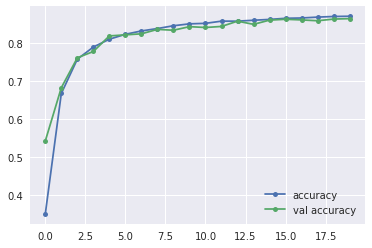

In [20]:
plt.plot(hist.history['acc'],ms=5,marker='o',label='accuracy')
plt.plot(hist.history['val_acc'],ms=5,marker='o',label='val accuracy')
plt.legend()
plt.show()

[回索引](#索引)

#### 2.g. 儲存模型和權重

In [21]:
import json
with open('first_try.json', 'w') as jsOut:
    json.dump(model.to_json(), jsOut)

model.save_weights('first_try.h5')

[回索引](#索引)

#### 2.h. 載入存好的模型和權重

In [22]:
from keras.models import model_from_json

In [23]:
with open('first_try.json', 'r') as jsIn:
    modelJson=json.load(jsIn)
    
modelLoaded=model_from_json(modelJson)
modelLoaded.load_weights('first_try.h5')

In [24]:
modelLoaded.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


[回索引](#索引)

#### 2.i. 輸出分類報告

In [25]:
predY=model.predict(testX).argmax(axis=1)
from sklearn.metrics import classification_report
print( classification_report(predY,testY) )

             precision    recall  f1-score   support

          0       0.95      0.91      0.93       363
          1       0.95      0.90      0.92       468
          2       0.80      0.86      0.83       320
          3       0.84      0.91      0.87       349
          4       0.91      0.91      0.91       331
          5       0.83      0.81      0.82       348
          6       0.90      0.91      0.91       383
          7       0.90      0.86      0.88       368
          8       0.86      0.80      0.83       346
          9       0.78      0.86      0.82       324

avg / total       0.88      0.87      0.88      3600



[回索引](#索引)

## 3. AlexNet-like Network

In [26]:
trainX=trainX.reshape(*trainX.shape,1)
trainValX=trainValX.reshape(*trainValX.shape,1)
testX=testX.reshape(*testX.shape,1)

#### 3.a. 建立模型

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D
from keras.layers import Activation
from keras.optimizers import SGD,Adam,Adamax

input_shape=(28,28,1)

model = Sequential()
#conv1
model.add(Conv2D(filters=32, kernel_size=(3, 3),
                activation='relu',
                input_shape=input_shape))
#conv2
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu')
         )
#pool1
model.add(MaxPooling2D(pool_size=(2, 2))
         )
#dropout1
model.add(Dropout(0.5))
model.add(Flatten())
#dense1
model.add(Dense(128, activation='relu')
         )
#dropout2
model.add(Dropout(0.5))
#dense2
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.1, momentum=0.0, decay=0.0) ,
              metrics=['accuracy'])

[回索引](#索引)

#### 3.b. 訓練模型

In [28]:
%%time 
hist=model.fit(trainX, trainYOneHot, 
               epochs=20,
               batch_size=128,
               validation_data=(trainValX,trainValYOneHot),
              )

Train on 12600 samples, validate on 1800 samples
Epoch 1/20
12600/12600 [==============================] - 1s - loss: 1.1730 - acc: 0.6094 - val_loss: 0.3077 - val_acc: 0.9122
Epoch 2/20
12600/12600 [==============================] - 0s - loss: 0.3537 - acc: 0.8925 - val_loss: 0.2286 - val_acc: 0.9333
Epoch 3/20
12600/12600 [==============================] - 0s - loss: 0.2507 - acc: 0.9257 - val_loss: 0.1716 - val_acc: 0.9500
Epoch 4/20
12600/12600 [==============================] - 0s - loss: 0.2076 - acc: 0.9383 - val_loss: 0.1337 - val_acc: 0.9561
Epoch 5/20
12600/12600 [==============================] - 0s - loss: 0.1693 - acc: 0.9471 - val_loss: 0.1117 - val_acc: 0.9606
Epoch 6/20
12600/12600 [==============================] - 0s - loss: 0.1561 - acc: 0.9527 - val_loss: 0.1146 - val_acc: 0.9633
Epoch 7/20
12600/12600 [==============================] - 0s - loss: 0.1375 - acc: 0.9594 - val_loss: 0.1040 - val_acc: 0.9639
Epoch 8/20
12600/12600 [==============================] - 0s -

[回索引](#索引)

#### 3.c. 檢視模型訓練結果

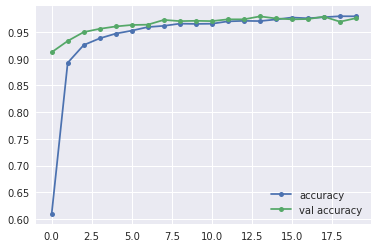

In [29]:
plt.plot(hist.history['acc'],ms=5,marker='o',label='accuracy')
plt.plot(hist.history['val_acc'],ms=5,marker='o',label='val accuracy')
plt.legend()
plt.show()

[回索引](#索引)

#### 3.d. 檢視模型準確率

In [30]:
score = model.evaluate(testX, testYOneHot, batch_size=128)
print()
print('\nloss=%s \naccuracy=%s'%(score[0],score[1]) )

3600/3600 [==============================] - 0s     


loss=0.0641309856996 
accuracy=0.981666666667


[回索引](#索引)

#### 3.e. 檢視分類報告

In [31]:
predY=model.predict(testX).argmax(axis=1)
from sklearn.metrics import classification_report
print( classification_report(predY,testY) )

             precision    recall  f1-score   support

          0       0.99      0.99      0.99       346
          1       0.98      0.99      0.99       438
          2       0.98      0.98      0.98       346
          3       0.98      0.98      0.98       375
          4       0.98      0.98      0.98       332
          5       0.99      0.96      0.98       351
          6       0.98      0.99      0.99       381
          7       0.97      0.99      0.98       348
          8       0.98      0.97      0.97       323
          9       0.98      0.98      0.98       360

avg / total       0.98      0.98      0.98      3600



[回索引](#索引)